# 感知器与神经网络 (Neural Networks)

### 逻辑回归模型的局限性

随着幂指数和初始特征组合方式的增加，输入特征的数量过多，造成计算成本过高。  
在图像识别中，一个50*50像素的图片，拥有的特征量为2500，那么它的二次项数大约为3百万个    

$  C_{50}^2 = \frac{2500 \times 2499}{2}= 3.12 \times 10^6 $  

神经网络的组成单元——神经元。神经元也叫做感知器。感知器算法在上个世纪50-70年代很流行，也成功解决了很多问题。

### 感知器模型

<img src="./images/perceptron.png">

- 输入权值：一个感知器可以接收多个输入，每个输入上有一个权值  
- 激活函数：感知器的激活函数可以有很多选择，如：sigmoid, tanh, ReLU   

### 感知器的局限性

数据必须要满足线性可分才能用此法，如果线性不可分，则永远执行下去

### 人脑的神经元

<img src="http://pic2.mofangge.com/upload/knowlageEx/09/20131123/2013112309544173620979.png">

神经元传导神经冲动是沿一定方向传导的，每个神经元可能有很多树突，但是只有一个轴突，树突将神经冲动传向细胞体，轴突则将冲动从细胞体传出。所以神经冲动的传导方向是树突→细胞体→轴突。

### 神经网络

有一种假说：“智能来源于单一的算法(One Learning Algorithm)”。如果这一假说成立，那么利用单一的算法(神经网络)处理世界上千变万化的问题就成为可能。我们不必对万事万物进行编程，只需采用以不变应万变的策略即可。有越来越多的证据证明这种假说，例如人类大脑发育初期，每一部分的职责分工是不确定的，也就是说，人脑中负责处理声音的部分其实也可以处理视觉影像

<img src="https://regmedia.co.uk/2016/10/14/neural_network_image_via_shutterstock.jpg?x=1200&amp;y=794" width="50%">

### 神经网络

应用示例：手写数字识别

#### 基于Sigmoid函数的神经元表达

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
import scipy.io # Used to load the OCTAVE *.mat files
import scipy.misc # Used to show matrix as an image
import matplotlib.cm as cm # Used to display images in a specific colormap
import random # To pick random images to display
from scipy.optimize import fmin_cg # fmin_cg to train neural network
import itertools
from PIL import Image

In [58]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

#### Sigmoid函数的梯度

In [59]:
def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

#### 加载数据

In [60]:
datafile = 'data/ex4data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']

In [61]:
# 加入Bias
X = np.insert(mat['X'],0,1,axis=1)

In [62]:
print("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape, np.unique(mat['y'])))
print("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


#### 可视化训练数据

In [63]:
# get single image
def getDatumImg(row, show=False):
    img = row[1:].reshape(20,20).T
    if show:
        plt.imshow(img,cmap = cm.Greys_r)
    else:
        return img

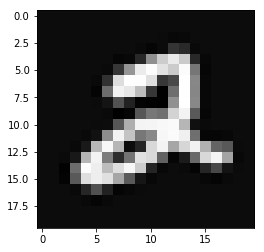

In [64]:
getDatumImg(X[1000], show=True)

In [65]:
def displayData(indices_to_display = None, size=(10,10)):
    width, height = 20, 20
    nrows, ncols = size
    if not indices_to_display:
        # Randomly select "size" images to display
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        # fill single image into "big_picture"
        big_picture[irow*height:(irow*height + iimg.shape[0]), icol*width:(icol*width + iimg.shape[1])] = iimg
        icol += 1
    fig = plt.imshow(big_picture,cmap='gray', extent=(0,100,0,100))

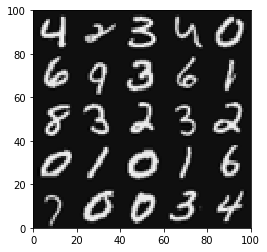

In [66]:
displayData(size=(5,5))

### 训练神经网络

#### 初始化神经网络模型

输入层：$ {20}\times{20}=400 $  
隐藏层：25  
输出层：10

In [67]:
num_labels = 10
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [68]:
def flattenParams(thetas_list):
    """Flatten theta matrices into a column array"""
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    print(flattened_list)
    combined = list(itertools.chain.from_iterable(flattened_list))
#     assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
#                             (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    """Reshape flatterned parameters into theta matrices"""
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size].reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:].reshape((output_layer_size,hidden_layer_size+1))
    return [ theta1, theta2 ]

def flattenX(myX):
    """Flatten X matrices into a column array"""
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    """Reshape flatterned X column array into X matrices"""
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

In [69]:
a = np.array([[-1,3],[2,-2]])
print(a)

[[-1  3]
 [ 2 -2]]


In [70]:
np.linalg.eig(a)

(array([ 1., -4.]), array([[ 0.83205029, -0.70710678],
        [ 0.5547002 ,  0.70710678]]))

#### 随机初始化权重系数

In [71]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 代价函数
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

#### L2正则化的代价函数
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [72]:
def computeCost(mythetas_flattened, myX_flattened, myy, mylambda=0.):
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)

    # Now unroll X
    myX = reshapeX(myX_flattened)

    # This is what will accumulate the total cost
    total_cost = 0.

    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in range(m):
        myrow = myX[irow]
        myhs = propagateForward(myrow, mythetas)[-1][1]
        tmpy = np.zeros((10, 1))
        tmpy[myy[irow] - 1] = 1

        # Compute the cost for this point and y-vector
        mycost = -tmpy.T.dot(np.log(myhs)) - (1 - tmpy.T).dot(np.log(1 - myhs))

        # Accumulate the total cost
        total_cost += mycost

    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m

    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta * mytheta)  # element-wise multiplication
    total_reg *= float(mylambda) / (2 * m)

    return total_cost + total_reg


def propagateForward(row, Thetas):
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features).reshape((Theta.shape[0], 1))
        a = sigmoid(z)
        zs_as_per_layer.append((z, a))
        if i == len(Thetas) - 1:
            return np.array(zs_as_per_layer)
        a = np.insert(a, 0, 1)  # Add the bias unit
        features = a


In [104]:
# myThetas = [ init_theta_1, init_theta_2 ]
myThetas = genRandThetas()
# print(computeCost(flattenParams(myThetas),flattenX(X),y))

In [79]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        
        theta2 = mythetas[1].T[1:,:]
        delta2 = theta2.dot(delta3) * sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [80]:
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.)
# print(flattenedD1D2)

[array([ 0.07354971, -0.02663793, -0.09285717, ..., -0.05078044,
       -0.06268464, -0.09867359]), array([-0.07156555, -0.02513823, -0.06465981,  0.07691787,  0.0650684 ,
        0.02907753, -0.00096356, -0.10452326,  0.08017568, -0.11722559,
        0.04934453,  0.01073867,  0.02665563, -0.06458332,  0.08678597,
        0.05819297, -0.09326661,  0.05585497,  0.00484543,  0.11391242,
       -0.01850794,  0.08735418,  0.10220637, -0.01479064,  0.06792417,
        0.07145949,  0.07215062, -0.07818507, -0.0501444 , -0.02572712,
       -0.0129643 ,  0.09478625, -0.08341529, -0.01148197,  0.11727865,
       -0.03853339,  0.02863882, -0.10914596,  0.03570141, -0.06692766,
        0.02190428, -0.10449196,  0.03708599,  0.01392437,  0.07160303,
       -0.0308217 , -0.01850973,  0.02798248, -0.06768837, -0.05138131,
        0.05511455, -0.04187403, -0.00337705, -0.00656746,  0.06901683,
       -0.10329307, -0.07552964, -0.05926169, -0.06687505,  0.06411911,
       -0.02810768, -0.08447829,  0.

In [81]:
def trainNN(mylambda=0.):
    randomThetas_unrolled = flattenParams(genRandThetas())
    result = fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=5,disp=True,full_output=True)
    return reshapeParams(result[0])

In [82]:
learned_Thetas = trainNN()

[array([ 0.03527453,  0.04530315,  0.08828683, ...,  0.00330687,
        0.00157327, -0.11418656]), array([ 0.05169536, -0.11941699,  0.02571683,  0.03994054,  0.11324086,
        0.11691385, -0.04061484, -0.11590978,  0.09224507,  0.03502876,
        0.02003048,  0.01641136, -0.00529764,  0.00178542,  0.05971703,
        0.08461026, -0.03053113,  0.0265918 , -0.05283249, -0.03288459,
        0.11054728,  0.10110235,  0.09548761, -0.03017619, -0.07929808,
        0.06338081, -0.06710348, -0.05991551, -0.079669  , -0.04933634,
        0.09974409,  0.04589037, -0.07522994,  0.02960612, -0.04634272,
       -0.07385386,  0.04049585,  0.039331  , -0.07338799,  0.09116352,
       -0.01302148,  0.01058243,  0.00045291, -0.10050963, -0.02517763,
        0.04546635, -0.03295995,  0.00452458,  0.0383077 ,  0.1083608 ,
        0.07671309, -0.05473509, -0.0698864 ,  0.01470806,  0.06199145,
        0.01045437,  0.01942213,  0.0921272 , -0.06910122, -0.0115169 ,
       -0.03021338,  0.00444752, -0.

[array([-1.08612630e-02,  0.00000000e+00,  0.00000000e+00, ...,
       -9.91087977e-09, -7.58269153e-10,  0.00000000e+00]), array([ 0.02368188,  0.00844373,  0.00854173,  0.01578639,  0.0139441 ,
       -0.00224157,  0.01092149,  0.01093022,  0.01098186,  0.00966341,
        0.00924049,  0.01037497,  0.01416847,  0.00905291,  0.00346468,
        0.01142146,  0.00713327,  0.00488092,  0.0076121 ,  0.01980278,
        0.02070974,  0.00207841,  0.0076334 ,  0.01449757,  0.01539394,
        0.01112745,  0.03074732,  0.01659322,  0.01712299,  0.01411815,
        0.0160846 ,  0.01237717,  0.01763623,  0.02091742,  0.01195775,
        0.00937567,  0.01614196,  0.01850762,  0.0116364 ,  0.0209225 ,
        0.01023908,  0.01784794,  0.01753949,  0.01709718,  0.01419479,
        0.01479388,  0.01828132,  0.01293195,  0.01017211,  0.02065899,
        0.01381245,  0.01578676,  0.02892833,  0.01598053,  0.01371414,
        0.0171334 ,  0.01318735,  0.00729066,  0.01963013,  0.01141948,
        0.00

[array([ 2.86155305e-03,  0.00000000e+00,  0.00000000e+00, ...,
        5.18890514e-08, -6.56084149e-09,  0.00000000e+00]), array([-6.50299211e-03, -5.06606233e-03, -6.87712004e-03, -5.97571218e-04,
        8.99991736e-04, -1.12987739e-02, -7.12243954e-03, -1.29713311e-03,
       -4.28482393e-03, -2.84307655e-03, -1.57676806e-03, -8.00375507e-04,
       -1.46908844e-03, -4.50895981e-03, -7.40016369e-03, -2.44177583e-03,
       -6.62825741e-03, -6.34540914e-03, -6.27838927e-03,  4.27333711e-03,
        1.26449331e-03, -9.34110190e-03, -3.55977739e-03,  3.02866806e-03,
       -1.49490263e-03, -3.45405552e-03, -7.12811932e-03, -4.12845471e-03,
       -3.96760106e-03, -8.21780594e-03, -1.14175992e-03,  1.37501347e-03,
       -7.12438164e-03,  2.82464613e-03, -8.05752313e-03, -7.23845150e-03,
        8.42728653e-04,  3.28693871e-03, -9.58762814e-03, -4.79441193e-04,
       -4.79066671e-03,  9.03522663e-04, -2.00668004e-03,  2.14787602e-03,
       -5.86941413e-03, -7.39015876e-03, -6.5483473

[array([ 1.28408756e-02,  0.00000000e+00,  0.00000000e+00, ...,
        1.56807851e-07, -7.77842695e-09,  0.00000000e+00]), array([-1.04430950e-02,  2.65572456e-03, -1.21544171e-02, -6.61300742e-03,
       -1.54115815e-02, -2.17622063e-02, -1.12351968e-02,  3.03165542e-03,
       -1.44724916e-02, -5.85126845e-03, -1.82669611e-03, -1.15564085e-03,
       -1.55240412e-03,  2.91170706e-03, -6.24189061e-03, -1.86835418e-02,
       -9.88465689e-03, -5.21618990e-03, -1.69175049e-03,  6.58708545e-03,
       -1.30253009e-02, -2.03043058e-02, -6.12776531e-03,  1.01422778e-02,
        4.46050122e-03, -6.98780168e-03, -3.32485803e-02, -2.27912952e-02,
       -1.74116146e-02, -2.92603337e-02, -1.98393334e-02, -1.02163592e-02,
       -2.63104337e-02, -1.56974943e-02, -2.33883311e-02, -1.33325264e-02,
       -1.18504529e-02, -6.05694832e-03, -2.04810872e-02, -2.51545110e-02,
       -1.45379140e-02, -6.40739502e-03, -2.26317647e-02, -1.33736508e-03,
       -2.09071842e-02, -2.91959253e-02, -2.7083081

[array([ 2.00531959e-02,  0.00000000e+00,  0.00000000e+00, ...,
        2.42359495e-07, -2.93096336e-09,  0.00000000e+00]), array([ 1.13607678e-02,  3.10495429e-02, -6.13399910e-03,  9.02331825e-04,
       -3.11892200e-02, -3.13652677e-02, -1.96650554e-03,  2.48980903e-02,
       -1.56908656e-02,  3.54773849e-03,  6.06860029e-03,  1.09224495e-02,
        1.29150834e-02,  2.55434872e-02,  8.72230342e-03, -2.85425021e-02,
        2.36960901e-03,  1.03430913e-02,  2.37694285e-02,  2.80414978e-02,
       -1.99221465e-02, -2.30171359e-02, -7.05611910e-04,  3.43300937e-02,
        3.39253599e-02,  1.46098917e-03, -3.82746287e-02, -2.89524313e-02,
       -1.14002823e-02, -3.97301274e-02, -2.88332625e-02, -1.74384431e-02,
       -3.21818488e-02, -2.79229197e-02, -2.19961748e-02, -8.90869357e-04,
       -1.30870127e-02, -5.51295719e-03, -9.76761757e-03, -4.19958777e-02,
       -1.15796654e-02, -3.96288347e-04, -3.60303463e-02,  8.05854555e-03,
       -2.06609012e-02, -3.84695636e-02, -3.4275789

[array([-2.23046230e-02,  0.00000000e+00,  0.00000000e+00, ...,
        5.66045884e-08,  8.99750723e-10,  0.00000000e+00]), array([ 0.07299089,  0.06533344,  0.03453585,  0.04570538, -0.01348759,
        0.00704218,  0.03785469,  0.03733281,  0.02913659,  0.04179258,
        0.00819404,  0.03017777,  0.03042703,  0.02432061,  0.04462641,
        0.01179518,  0.05530577,  0.04461848,  0.0559125 ,  0.05620634,
        0.02222089,  0.01740242,  0.00731135,  0.06872002,  0.05682646,
        0.01149601,  0.07030519,  0.07581661,  0.0290595 ,  0.04939826,
       -0.01247875,  0.00508475, -0.00223807, -0.00457953,  0.07782678,
        0.074297  ,  0.02346607,  0.00604676,  0.0426814 , -0.01737082,
        0.08366458,  0.01779313,  0.03945364,  0.02972669,  0.08059603,
        0.05902254,  0.0145483 ,  0.01697496,  0.0055696 ,  0.06776529,
        0.05229877, -0.00865521,  0.05027261,  0.01556887,  0.02262858,
        0.04593619,  0.01758396,  0.02910557,  0.04373078,  0.02647454,
        0.04

In [83]:
print(np.array(learned_Thetas[0]).T.shape)
print(np.array(learned_Thetas[1]).T.shape)

(401, 25)
(26, 10)


In [105]:
def predictNN(row,Thetas):
    classes = [i for i in range(1,10)] + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [106]:
computeAccuracy(X, myThetas, y)
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 4.2%
Training set accuracy: 49.9%


In [86]:
learned_regularized_Thetas = trainNN(mylambda=10.)

[array([-0.06805859,  0.11942933,  0.01510902, ...,  0.11527197,
       -0.08569471, -0.1198846 ]), array([ 0.0300602 ,  0.04880624,  0.09778201,  0.06079829,  0.11324362,
       -0.02388459, -0.02567494,  0.00369559,  0.11226803, -0.00437476,
        0.02831633, -0.0315408 , -0.06783746, -0.07805798, -0.02079401,
       -0.09276842,  0.03719254, -0.02472459,  0.04640301, -0.05587424,
       -0.11916586, -0.08963935,  0.03251108,  0.11653633,  0.04704787,
       -0.0226592 , -0.07636002, -0.01700589,  0.0246648 ,  0.05841279,
        0.03429581, -0.10740071,  0.02054271,  0.03611567,  0.03909524,
        0.03613884,  0.00505898, -0.01953172, -0.106852  ,  0.02631949,
        0.06897812, -0.02851546,  0.05096756,  0.04310516, -0.03425035,
       -0.05599363,  0.0888669 ,  0.00200936,  0.02790093, -0.07047639,
       -0.05480627,  0.06466574, -0.0599573 , -0.02516253,  0.07869742,
       -0.09970005, -0.05472584, -0.10024792, -0.10064767,  0.11725915,
        0.04487244, -0.07579384,  0.

[array([-1.02331888e-02,  2.38523616e-04,  3.01756585e-05, ...,
        2.30139771e-04, -1.71140339e-04, -2.39432883e-04]), array([0.02869302, 0.01785494, 0.00061304, 0.00596673, 0.00809216,
       0.01320022, 0.01172194, 0.01528671, 0.01813516, 0.01976176,
       0.00972908, 0.01971479, 0.02136351, 0.00084879, 0.00748567,
       0.01709346, 0.00512482, 0.00757094, 0.00674987, 0.01628515,
       0.01556286, 0.01649187, 0.0087196 , 0.00695408, 0.00015095,
       0.0114014 , 0.02949617, 0.018975  , 0.01021539, 0.01087021,
       0.01249655, 0.02021947, 0.010165  , 0.01186998, 0.01145891,
       0.02339654, 0.00978168, 0.01839448, 0.00781111, 0.01598668,
       0.00865501, 0.0156988 , 0.01323214, 0.00872646, 0.01342454,
       0.01380726, 0.0174066 , 0.01587141, 0.01874699, 0.01182402,
       0.00974327, 0.02112778, 0.03265658, 0.01439783, 0.0056254 ,
       0.01558608, 0.01631692, 0.01233537, 0.01934606, 0.01867388,
       0.02028356, 0.0176276 , 0.01220619, 0.01630011, 0.01382179,
     

[array([ 1.97071708e-03,  2.37469754e-04,  3.00423343e-05, ...,
        2.29186571e-04, -1.70390852e-04, -2.38375004e-04]), array([-4.63320765e-03,  3.10020702e-04, -1.24244732e-02, -8.57685893e-03,
       -5.98408364e-03, -2.64402652e-03, -3.19126169e-03, -8.95473079e-04,
        1.21804172e-03, -1.12467895e-03, -2.40498540e-03,  2.51034640e-03,
        2.71943597e-03, -9.05152735e-03, -6.60987192e-03,  2.84261211e-04,
       -8.16490574e-03, -1.45585205e-03, -8.69860148e-03,  4.21526104e-03,
       -4.71184654e-03,  1.75529364e-03, -4.81343858e-03, -5.50442917e-03,
       -9.50054438e-03, -2.48987724e-03, -5.33503369e-03,  6.76752172e-05,
       -3.28206033e-03, -5.42542345e-03, -3.27510176e-03,  3.03227614e-03,
       -7.22170803e-03, -6.82295003e-03, -6.45234388e-03, -1.15161168e-03,
       -3.61780373e-03, -1.98025377e-03, -1.28616886e-02,  3.87272409e-03,
       -8.16219976e-03, -4.39876098e-03, -2.64388545e-03, -2.53540470e-03,
       -4.58730651e-03, -1.24274396e-03, -6.3505558

[array([ 3.98824036e-03,  2.25933456e-04,  2.85828756e-05, ...,
        2.18315197e-04, -1.62134678e-04, -2.26794729e-04]), array([-2.33147022e-02, -1.63817283e-02, -2.77310141e-02, -2.81590730e-02,
       -1.88295683e-02, -1.61946600e-02, -8.97028179e-03, -1.01091483e-02,
       -1.65124917e-02, -1.27510306e-02, -8.55212769e-03, -3.49787763e-03,
       -5.57742863e-03, -3.09153477e-03, -1.94277053e-02, -3.59442773e-03,
       -1.24792889e-02, -8.87680213e-04, -1.84948466e-02,  5.02272763e-03,
       -1.73646553e-02,  4.11738490e-03, -2.03762806e-02, -2.04555144e-02,
       -1.60896679e-02, -1.01716384e-02, -2.14585763e-02, -3.56016830e-03,
       -5.79290618e-03, -2.03207018e-02, -1.17403381e-02,  2.10764295e-03,
       -1.27786732e-02, -1.72573122e-02, -1.12735360e-02, -1.84167986e-02,
       -3.55956689e-03, -1.09365236e-02, -2.22452129e-02,  3.49446730e-04,
       -2.28430445e-02, -1.37215410e-02, -1.18987828e-02, -1.26705466e-02,
       -1.40392885e-02, -8.91777828e-03, -2.2720964

[array([-2.96098530e-03,  1.76474786e-04,  2.23258517e-05, ...,
        1.70966725e-04, -1.26680890e-04, -1.77147519e-04]), array([-0.01776413, -0.02195354, -0.02713912, -0.0266413 , -0.01347349,
       -0.02003001,  0.00320004, -0.00371633, -0.01330263, -0.01300651,
       -0.00546277,  0.00222657, -0.00191794,  0.01174213, -0.01815148,
        0.00277553,  0.00024877,  0.00464163, -0.01095062,  0.00540225,
       -0.01372027,  0.01093753, -0.02374612, -0.02469275, -0.01325965,
       -0.00824786, -0.0418496 , -0.00093076, -0.0095573 , -0.04447456,
       -0.01169853,  0.00238632, -0.00807872, -0.02305226,  0.0006082 ,
       -0.04492671,  0.00289766, -0.0227097 , -0.03504621, -0.00387329,
       -0.04459895, -0.03153137, -0.0243896 , -0.03445842, -0.02014271,
       -0.03425726, -0.04487579, -0.04314534, -0.01473968, -0.01147228,
       -0.00560605, -0.04175923,  0.01994462,  0.00963623, -0.01308457,
        0.01530053,  0.00890089,  0.01046498,  0.01548141, -0.00580349,
        0.00

In [87]:
computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 57.3%


In [101]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
#     assert myTheta.shape == (25,400)
    print(myTheta.shape)
#     return
    width, height = 20, 20
    nrows, ncols = 5, 5
        
#     big_picture = np.zeros((height*nrows,width*ncols))
    big_picture = np.zeros(myTheta.T.shape)
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.imshow(big_picture,cmap='gray', extent=(0,100,0,100))

In [102]:
displayHiddenLayer(learned_Thetas[0])

(25, 400)


ValueError: could not broadcast input array from shape (20,20) into shape (20,5)